# Airbnb Seattle Data Analysis

In [614]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

In [380]:
calendar = pd.read_csv('./calendar.csv')
listings = pd.read_csv('./listings.csv')
reviews = pd.read_csv('./reviews.csv')

## Quick Datasets View

In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [600]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [432]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Choose our questions

The questions I aim to solve in this exploration are:
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- What is the most expensive neighbourhood?
- Do hosts with higher rating have higher revenue?
- Which facilities of the house contribute more to the price?

# What are the busiest times to visit Seattle?

Let's extract calendar values where we have the date and the availability = false

In [602]:
cal = calendar.copy()
# Convert Pandas Series in datetime format so we can manipulate them
cal["date"] = pd.to_datetime(cal['date'])

In [603]:
# New column with a new column referring to month and year
cal['month_year'] = cal['date'].dt.to_period('M')

In [604]:
# Quick view to cal Dataframe
cal.head()

,listing_id,date,available,price,month_year
0,241032,2016-01-04,t,$85.00,2016-01
1,241032,2016-01-05,t,$85.00,2016-01
2,241032,2016-01-06,f,NaN,2016-01
3,241032,2016-01-07,f,NaN,2016-01
4,241032,2016-01-08,f,NaN,2016-01


In [691]:
# Calculate distribution of the two possible values of the Available column and obtain %
cal_perc = cal.groupby(["month_year", "available"], as_index=False).size().reset_index(name='counts')
a = cal.groupby('month_year')['available'].transform('count')
cal_perc['perc'] = cal_perc['counts'].div(a)

In [693]:
cal_perc.describe

<bound method NDFrame.describe of    month_year available  counts      perc
0     2016-01         f   47665  0.445867
1     2016-01         t   59239  0.554133
2     2016-02         f   37401  0.349856
3     2016-02         t   73321  0.685858
4     2016-03         f   34420  0.321971
5     2016-03         t   83938  0.785172
6     2016-04         f   38503  0.360164
7     2016-04         t   76037  0.711264
8     2016-05         f   38387  0.359079
9     2016-05         t   79971  0.748064
10    2016-06         f   37296  0.348874
11    2016-06         t   77244  0.722555
12    2016-07         f   44136  0.412856
13    2016-07         t   74222  0.694286
14    2016-08         f   42011  0.392979
15    2016-08         t   76347  0.714164
16    2016-09         f   37294  0.348855
17    2016-09         t   77246  0.722574
18    2016-10         f   35920  0.336002
19    2016-10         t   82438  0.771140
20    2016-11         f   32760  0.306443
21    2016-11         t   81780  0.764985


In [608]:
# Exclude the not available column and drop the column of the year 2017 (not enough data)
cal_perc = cal_perc[cal_perc["available"] == "t"]
cal_perc = cal_perc.drop(25)

In [609]:
cal_perc

,month_year,available,counts,perc
1,2016-01,t,59239,0.554133
3,2016-02,t,73321,0.685858
5,2016-03,t,83938,0.785172
7,2016-04,t,76037,0.711264
9,2016-05,t,79971,0.748064
11,2016-06,t,77244,0.722555
13,2016-07,t,74222,0.694286
15,2016-08,t,76347,0.714164
17,2016-09,t,77246,0.722574
19,2016-10,t,82438,0.771140


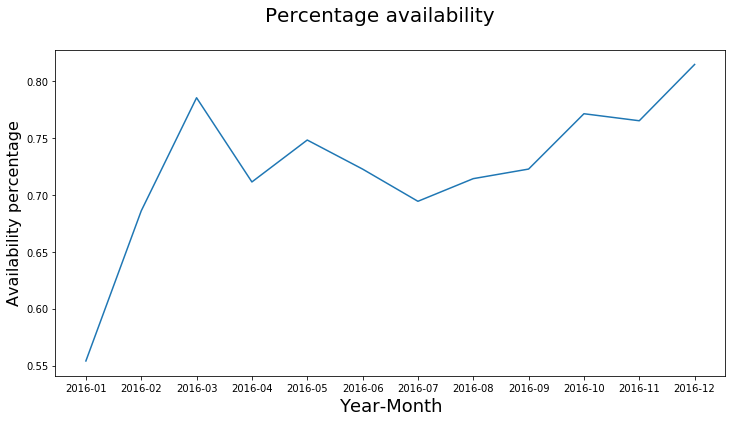

In [611]:
# Plot the percentage availability of the listings in Seattle
ax = plt.gca()
#ax.set_ylim([0, 1])
plt.suptitle('Percentage availability', fontsize=20)
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Availability percentage', fontsize=16)
x_my = cal_perc["month_year"].astype(str)
y_ap = cal_perc["perc"]
plt.plot(x_my, y_ap)
plt.show()

As we can see the busiest time to visit Seattle seems to be January, with a percentage availability of about 55%.
Similarly, April and July got lower availability values compared to others.

# By how much do prices spike?

The second question we want to answer is strictly connected to the one we have just answered, let's see how much do prices spike when the availability lower.

In [615]:
# Remove Nan rows (these rows are the ones where the listing is not available)
cal_with_price = cal.dropna(subset = ["price"])

In [616]:
# Remove the dollar sign in the price and convert it into float64
cal_with_price["price"] = cal_with_price["price"].replace( '[\$,)]','', regex=True ).astype(float)

In [617]:
cal_with_price = cal_with_price.groupby(["month_year"], as_index=False)["price"].mean() 
cal_with_price = cal_with_price.drop(12)

In [618]:
cal_with_price

,month_year,price
0,2016-01,121.568409
1,2016-02,124.293927
2,2016-03,128.644488
3,2016-04,135.097005
4,2016-05,139.538183
5,2016-06,147.473137
6,2016-07,152.094150
7,2016-08,150.656594
8,2016-09,143.255949
9,2016-10,137.031939


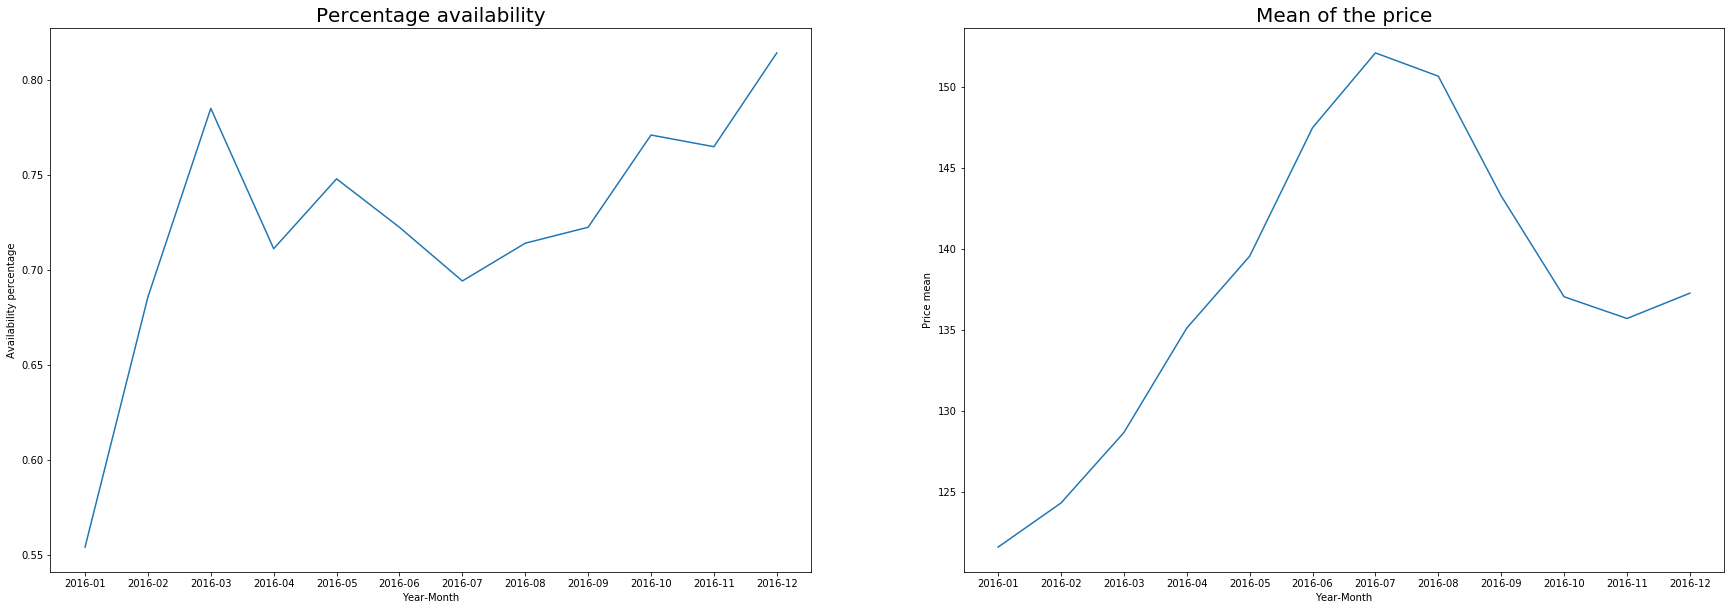

In [629]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(30,10))
# Percentage availability
ax1.set_title('Percentage availability', fontsize=20)
ax1.set(xlabel='Year-Month', ylabel='Availability percentage')
x_my = cal_perc["month_year"].astype(str)
y_ap = cal_perc["perc"]
ax1.plot(x_my, y_ap)
# Price
ax2.set_title('Mean of the price', fontsize=20)
ax2.set(xlabel='Year-Month', ylabel='Price mean')
x = cal_with_price["month_year"].astype(str)
y = cal_with_price["price"]
ax2.plot(x, y)

We can check if there is a correlation between the percentage availability and the mean of the price of the listings.

In [628]:
cal_with_price["price"].corr(cal_perc["perc"])

0.77806796957704

# What is the most expensive neighbourhood?

In [139]:
# These are all the neighbourhoods listed in Seattle
listings["neighbourhood"].unique()

array(['Queen Anne', nan, 'Ballard', 'Phinney Ridge', 'Fremont',
       'Lower Queen Anne', 'Westlake', 'Wallingford', 'Green Lake',
       'Minor', 'Madrona', 'Harrison/Denny-Blaine', 'Leschi',
       'University District', 'Roosevelt', 'Madison Park', 'Capitol Hill',
       'Atlantic', 'North Beacon Hill', 'Central Business District',
       'Pike Place Market', 'Pike Market', 'Eastlake', 'Portage Bay',
       'South Lake Union', 'Magnolia', 'Belltown',
       'International District', 'Yesler Terrace', 'First Hill',
       'Pioneer Square', 'Gatewood', 'The Junction', 'Arbor Heights',
       'Alki', 'North Admiral', 'Crown Hill', 'Genesee', 'Fairmount Park',
       'Interbay', 'Industrial District', 'Holly Park',
       'South Beacon Hill', 'Greenwood', 'Bitter Lake', 'Fauntleroy',
       'Mount Baker', 'Columbia City', 'Seward Park', 'Brighton',
       'South Delridge', 'Highland Park', 'High Point', 'View Ridge',
       'Windermere', 'Dunlap', 'Rainier Beach', 'North Delridge',
  

In [630]:
# Remove Nan rows (these rows are the ones where the listing is not available)
lst_neigh_price = listings.dropna(subset = ["neighbourhood", "price"])
# Convert price to float
lst_neigh_price["price"] = lst_neigh_price["price"].replace( '[\$,)]','', regex=True ).astype(float)
# SUbset df
lst_neigh_price = lst_neigh_price[["neighbourhood", "price"]]

In [631]:
lst_neigh_price = lst_neigh_price.groupby(["neighbourhood"], as_index=False)["price"].mean()
lst_neigh_price = lst_neigh_price.sort_values(by=['price'], ascending=False)
lst_neigh_price

,neighbourhood,price
17,Fairmount Park,370.000000
31,Industrial District,245.000000
58,Portage Bay,241.428571
78,Westlake,197.000000
0,Alki,196.652174
...,...,...
23,Georgetown,77.000000
60,Rainier Beach,76.722222
15,Dunlap,75.461538
52,Olympic Hills,63.666667


<BarContainer object of 10 artists>

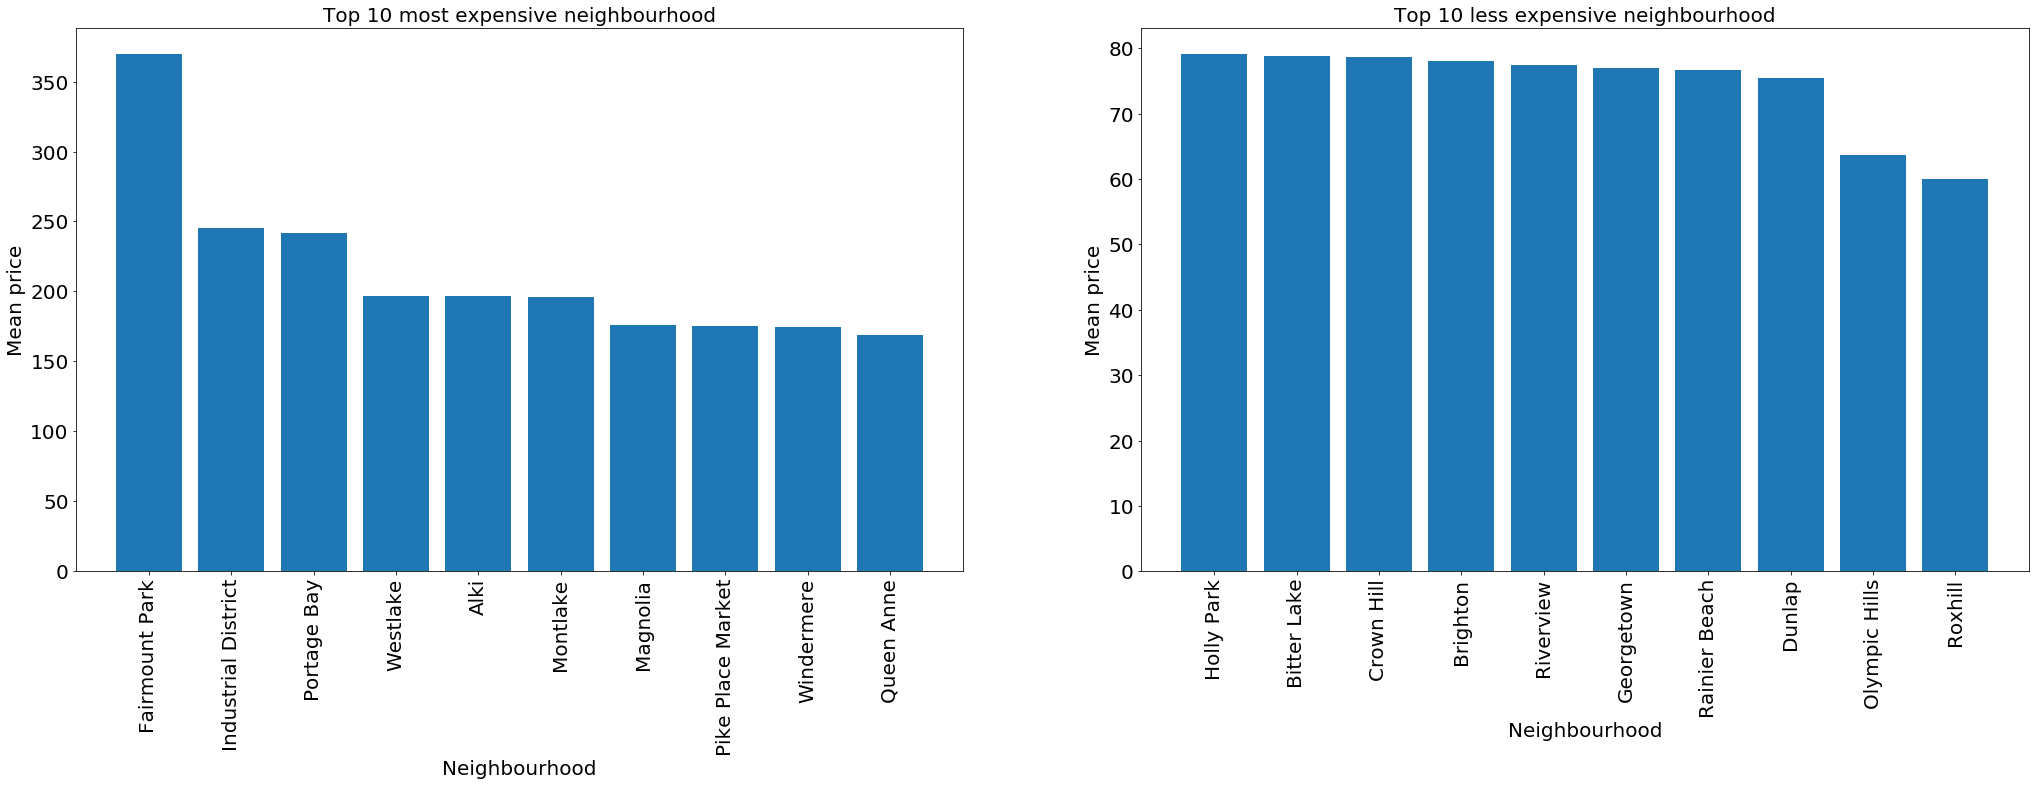

In [661]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(35,10))
# Top 10 most expensive neighbourhood
ax1.set_title('Top 10 most expensive neighbourhood', fontsize=20)
ax1.set_xlabel('Neighbourhood', fontsize=20)
ax1.set_ylabel('Mean price', fontsize=20)
x_top = lst_neigh_price["neighbourhood"]
y_top = lst_neigh_price["price"]
ax1.tick_params(axis='x', rotation=90)
ax1.tick_params(axis='both', labelsize=20)
#ax1.tick_params(labelrotation=45)
ax1.bar(x_top.head(10), y_top.head(10))
# Price
ax2.set_title('Top 10 less expensive neighbourhood', fontsize=20)
ax2.set_xlabel('Neighbourhood', fontsize=20)
ax2.set_ylabel('Mean price', fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
x_bottom = lst_neigh_price["neighbourhood"]
y_bottom = lst_neigh_price["price"]
ax2.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='both', labelsize=20)
ax2.bar(x_top.tail(10), y_top.tail(10))

# Do hosts with higher rating have higher revenue?

In [665]:
# Remove Nan rows (these rows are the ones where the listing is not available)
lst_rating_price = listings.dropna(subset = ["review_scores_value", "price"])
# Convert price to float
lst_rating_price["price"] = lst_rating_price["price"].replace( '[\$,)]','', regex=True ).astype(float)
#lst_rating_price

In [666]:
lst_rating_price["true_rating"] = lst_rating_price["review_scores_value"] / lst_rating_price["number_of_reviews"]

In [667]:
# SUbset df
lst_rating_price = lst_rating_price[["review_scores_value", "price", "true_rating", "number_of_reviews"]]
lst_rating_price

,review_scores_value,price,true_rating,number_of_reviews
0,10.0,85.0,0.048309,207
1,10.0,150.0,0.232558,43
2,10.0,975.0,0.500000,20
4,9.0,450.0,0.236842,38
5,10.0,120.0,0.588235,17
...,...,...,...,...
3810,8.0,154.0,1.600000,5
3811,10.0,65.0,5.000000,2
3812,10.0,95.0,0.136986,73
3813,8.0,359.0,8.000000,1


In [670]:
# Group every listing by the available days and merge with the price and the rating
lst_availability = calendar.groupby(["listing_id", "available"], as_index=False).size().reset_index(name='counts').pivot(index="listing_id", columns="available", values="counts")
lst_availability = lst_availability.fillna(0)
lst_availability = lst_availability.reset_index().rename_axis(None, axis=1)
lst_availability = lst_availability.merge(listings[["id","price", "review_scores_value", "number_of_reviews"]], how="left", left_on='listing_id', right_on='id').drop(columns = ['id'])
lst_availability = lst_availability.dropna(subset = ["price", "review_scores_value"])
# Convert price to float
lst_availability["price"] = lst_availability["price"].replace( '[\$,)]','', regex=True ).astype(float)

In [671]:
lst_availability

,listing_id,f,t,price,review_scores_value,number_of_reviews
1,4291,0.0,365.0,82.0,9.0,35
2,5682,56.0,309.0,48.0,10.0,297
3,6606,0.0,365.0,90.0,9.0,52
4,7369,312.0,53.0,85.0,9.0,40
5,9419,0.0,365.0,90.0,9.0,79
...,...,...,...,...,...,...
3723,9970805,0.0,365.0,39.0,10.0,1
3729,9995551,5.0,360.0,79.0,10.0,1
3733,10012724,318.0,47.0,25.0,10.0,2
3736,10020221,30.0,335.0,55.0,10.0,1


We assert that when the listing is not available it means it is already booked.
So calculate the estimated revenue using (n° of days which the listing is not available) * (listing price)

In [672]:
lst_availability["revenue"] = lst_availability["f"] * lst_availability["price"]

Now obtain a true rating of the listing dividing the revie_scores_value per the number of reviews.

In [673]:
# The more is true rating high, the more the listing is valuable
lst_availability["true_rating"] = lst_availability["review_scores_value"] * lst_availability["number_of_reviews"]

In [674]:
lst_availability["revenue"].corr(lst_availability["true_rating"])

-0.11710122612312655

There seem to be no correlation between the revenue of a listing and its rating.

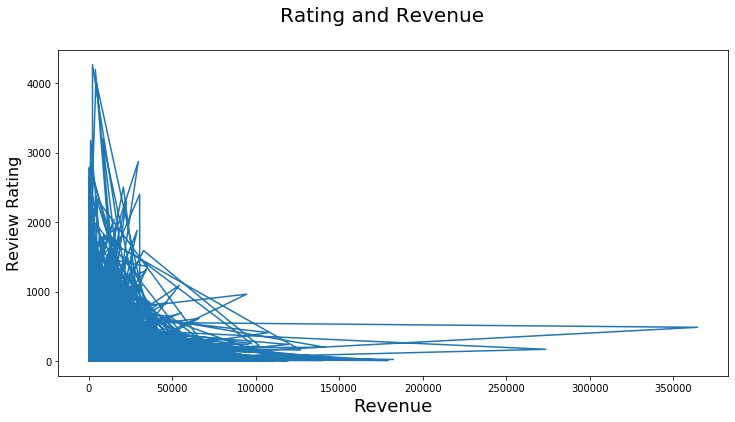

In [675]:
ax = plt.gca()
plt.suptitle('Rating and Revenue', fontsize=20)
plt.xlabel('Revenue', fontsize=18)
plt.ylabel('Review Rating', fontsize=16)
x = lst_availability["revenue"] 
y = lst_availability["true_rating"]
plt.plot(x, y)
plt.show()

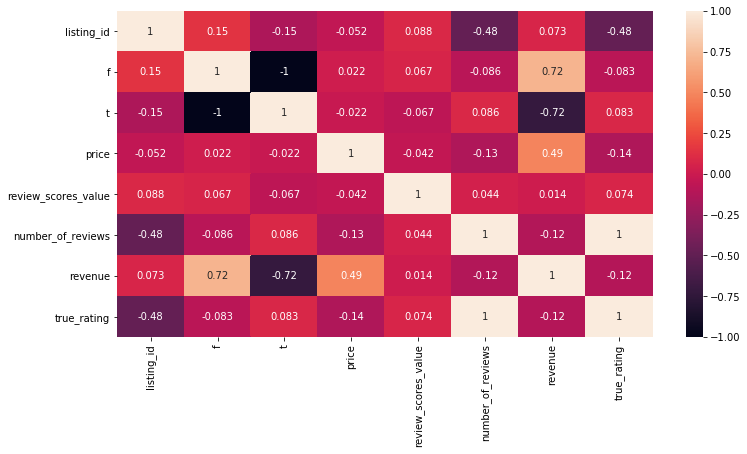

In [676]:
import seaborn as sns
sns.heatmap(lst_availability.corr(), annot=True)

# Which facilities of the house contribute more to the price?

In [677]:
facilities = listings[['property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price']]

In [678]:
# Split the facilities in columns, then clean the column names
new = facilities["amenities"].str.split(pat = ',', expand=True).apply(lambda x : x.value_counts(), axis = 1).fillna(0).astype(int)
new.columns = new.columns.str.replace('[{,",}]', '')

In [679]:
new = new.groupby(level=0, axis=1).sum()
new = new.drop(columns = [""], axis = 1)

In [680]:
fct = pd.concat([facilities, new], axis = 1)

In [681]:
fct = fct.drop(columns = ["amenities"])
fct = fct.dropna(subset = ["price"])
# Convert price to float
fct["price"] = fct["price"].replace( '[\$,)]','', regex=True ).astype(float)

In [682]:
fct.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,24-Hour Check-in,Air Conditioning,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,0,0,...,1,0,1,0,0,1,1,0,0,1
2,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975.0,0,1,...,0,1,1,0,0,1,1,0,0,1
3,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,100.0,0,0,...,1,1,1,0,0,0,1,0,0,1
4,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,450.0,0,0,...,0,1,1,0,0,1,0,0,0,1


In [683]:
# Fill NA values with mean
# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fct = fct.select_dtypes(include=['float', 'int']).apply(fill_mean, axis=0)

In [684]:
# Model
X = fct.drop(columns = ["price"])
y = fct["price"]

In [685]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [686]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [694]:
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model was 0.5334145270329917 on 1146 values.'

In order to answer the question, extract from the model the coefficients that influence more the price

In [695]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
12,Doorman,38.467885,38.467885
42,Washer / Dryer,-27.740929,27.740929
1,bathrooms,27.643745,27.643745
2,bedrooms,26.068509,26.068509
14,Elevator in Building,23.391739,23.391739
0,accommodates,16.400343,16.400343
24,Hot Tub,15.654075,15.654075
38,Smoking Allowed,-11.834369,11.834369
6,Breakfast,-11.651003,11.651003
8,Cable TV,10.764116,10.764116
